# Image deconvolution

In [89]:
# Import some libraries

import numpy as np
from skimage import color, data, restoration
import matplotlib.pyplot as plt
import scipy
from scipy.signal import fftconvolve, convolve
from scipy.signal import convolve2d
from skimage import io
import skimage
from scipy import fftpack
import warnings

warnings.filterwarnings("ignore")

In [90]:
# Define function to show images


def show_images(im1, im1_title, im2, im2_title, im3, im3_title, font):
    fig, (image1, image2, image3) = plt.subplots(1, 3, figsize=(15, 50))
    image1.imshow(im1, cmap="gray")
    image1.set_title(im1_title, fontsize=font)
    image1.set_axis_off()
    image2.imshow(im2, cmap="gray")
    image2.set_title(im2_title, fontsize=font)
    image2.set_axis_off()
    image3.imshow(im3, cmap="gray")
    image3.set_title(im3_title, fontsize=font)
    image3.set_axis_off()
    fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
    fig.show()

Image formation process can be described by the convolution model

$\mathbf{y} = \mathbf{k} \ast \mathbf{x} + \mathbf{n}$,

where $\mathbf{y}$ is the resulting blurred and noisy image, $\mathbf{k}$ is the blurring kernel, or point spread function of a system (PSF), $\mathbf{x}$ is the underlying image that we aim to restore and $\mathbf{n}$ ~ $\mathcal{N}(0, \sigma^{2})$ denotes noise, which is assumed to follow i.i.d Gaussian distribution.

The goal of this homework is to show how one can restore an image distorted with blur and noise with some widely used deconvolution algorithm(s) and see how regularization improves the result.


(256, 256) (256, 256) (256, 256) (15, 15)


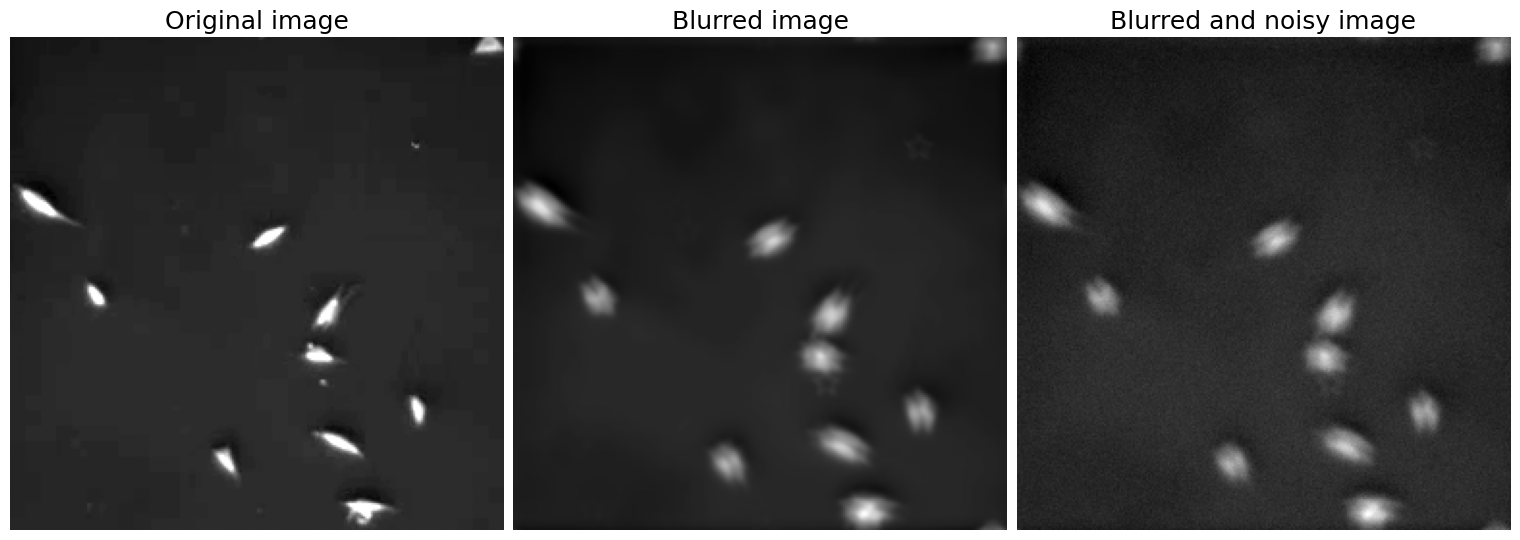

In [91]:
# Load the blurred and noisy image and the kernel

data = np.load("./2025_data.npz")
gt = data["arr_0"]
blurred = data["arr_1"]
distorted = data["arr_2"]
psf = data["arr_3"]

show_images(gt, "Original image", blurred, "Blurred image", distorted, "Blurred and noisy image", font=18)

print(gt.shape, blurred.shape, distorted.shape, psf.shape)

**a)** Try to understand what is the shape of the blurring kernel in this task by looking at the distorted images. Did your conclusions match the actual shape of the psf = data['arr_3']? *(1 point)*

**YOUR ANSWER:**
The shape of the PSF is (15,15) which matches my expectation as we see moderate blurring on blurred image which points to the moderate size of PSF.

The common practice in optics is to normalize blurring kernel such that

$\sum_{i,j}k_{i,j} = 1$.

This is done to keep the same range of values.

In [92]:
# SOLUTION

print("Before normalization", psf.sum())

psf = psf / psf.sum()

Before normalization 1.0


Sum of PSF elements: 1.0


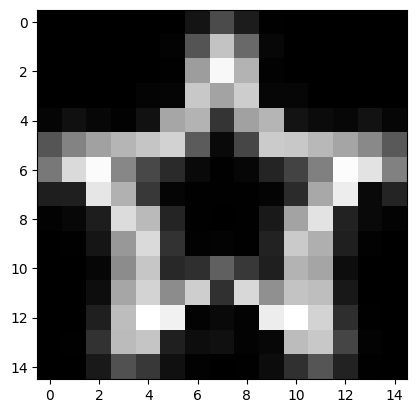

In [93]:
plt.imshow(psf, cmap="gray")
print("Sum of PSF elements:", psf.sum())

In this homework we will consider three deconvolution approaches:
1. Naive approach
2. Wiener filter
3. Wiener filter with regularization

## Naive approach

**b)** Let's remember that, convolution of two signals (or images in our case) is equal to the pointwise multiplication of their Fourier transforms, i.e.

$y(i,j) = k(i,j) \ast x(i,j) + n(i,j)$ <--> $Y(u,v) = K(u,v)X(u,v) + N(u,v)$

Consequently, the simplest approach in deconvolution is to perform element-wise division in the Fourier domain to find the underlying image $\textit{x}$:

$\hat{X}(u,v) = \frac{Y(u,v)}{K(u,v)} = \frac{K(u,v)X(u,v) + N(u,v)}{K(u,v)} = \frac{K(u,v)X(u,v)}{K(u,v)} + \frac{N(u,v)}{K(u,v)}$,

$\hat{x}(i,j) = F^{-1}\hat{X}(u,v)$


*2 points*

(256, 256)


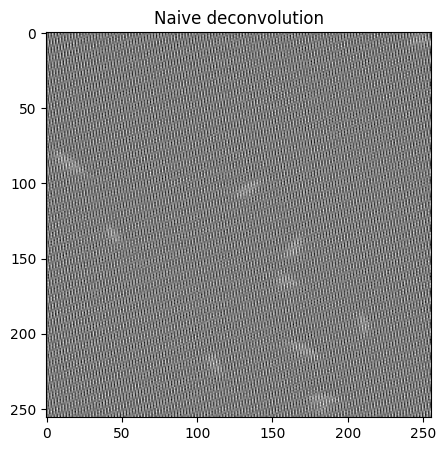

(256, 256)


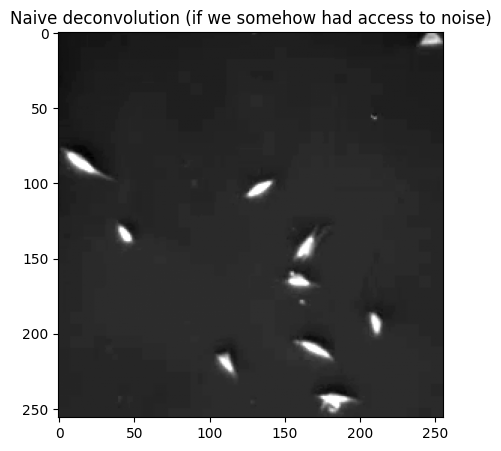

In [94]:
# SOLUTION
"""
YOUR CODE HERE
"""

from numpy import ndarray
from scipy.fft import fft2, ifft2, ifftshift

Y: ndarray = fft2(distorted)

k_padding = ((distorted.shape[0] - psf.shape[0] + 1) // 2, (distorted.shape[1] - psf.shape[1] + 1) // 2)
K = np.zeros(distorted.shape)
K[k_padding[0] : k_padding[0] + psf.shape[0], k_padding[1] : k_padding[1] + psf.shape[1]] = psf
K = fft2(ifftshift(K))

X_hat_naive = Y / K

x_hat_naive = ifft2(X_hat_naive).real
print(x_hat_naive.shape)

plt.figure(figsize=(5, 5))
plt.imshow(x_hat_naive, cmap="gray")
plt.title("Naive deconvolution")
plt.show()

noise = distorted - blurred
N: ndarray = fft2(noise)
X_hat_ideal = X_hat_naive - N / K

x_hat_ideal = ifft2(X_hat_ideal).real
print(x_hat_ideal.shape)

plt.figure(figsize=(5, 5))
plt.imshow(x_hat_ideal, cmap="gray")
plt.title("Naive deconvolution (if we somehow had access to noise)")
plt.show()

## Wiener filter

One of the most popular an widely-used deconvolution algorithms is Wiener filter. Wiener filter retrieves the maximum likelihood estimation uder the assumption of Gaussian noise

$\hat{\mathbf{x}} = \arg\!\min_{\mathbf{x}}\frac{1}{2}||\mathbf{y}-\mathbf{Kx}||^{2}_{2}$.

Solving this equation, one yields the solution in the form

$\hat{\mathbf{x}} = (\mathbf{K}^{\top}\mathbf{H})^{-1}\mathbf{K}^{\top}\mathbf{y}$.

Under assumption of periodic boundary conditions matrix $\textbf{K}$ is a circulant matrix, so the solution can be formulated in the frequency domain as

$\hat{X}(u,v) = \frac{K^{*}(u,v)}{|K(u,v)|^{2}}Y(u,v)$. The term $\frac{K^{*}(u,v)}{|K(u,v)|^{2}}$ is called Wiener filter.

Do not forget that $\hat{x}(i,j) = F^{-1}\hat{X}(u,v)$.

*2 points*

(256, 256)


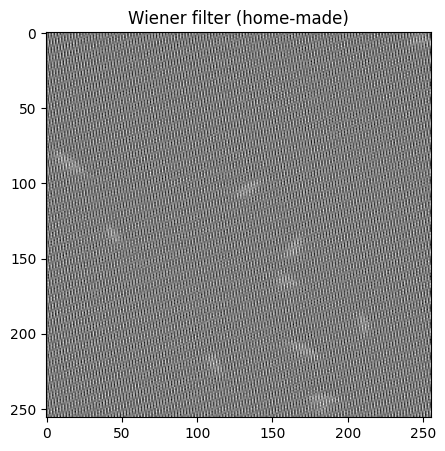

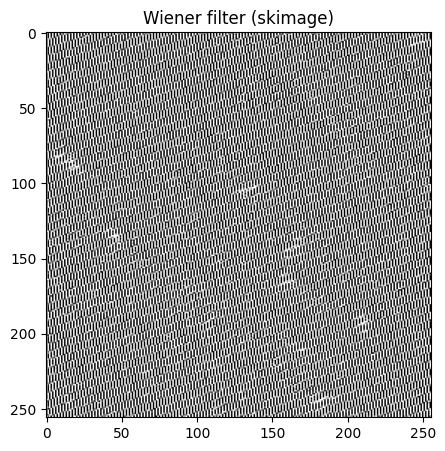

In [95]:
# SOLUTION

# Do all necessary modifications with the PSF before
# applying Fourier transform:

"""
YOUR CODE HERE
"""

from numpy import ndarray, linalg
from scipy.fft import fft2, ifft2, ifftshift
from skimage.restoration import wiener

Y: ndarray = fft2(distorted)

k_padding = ((distorted.shape[0] - psf.shape[0] + 1) // 2, (distorted.shape[1] - psf.shape[1] + 1) // 2)
K = np.zeros(distorted.shape)
K[k_padding[0] : k_padding[0] + psf.shape[0], k_padding[1] : k_padding[1] + psf.shape[1]] = psf
K: ndarray = fft2(ifftshift(K))

wiener_filter = K.conj() / (np.abs(K) ** 2)

X_hat_wf = wiener_filter * Y

x_hat_wf = ifft2(X_hat_wf).real
x_hat_wf = x_hat_wf / x_hat_wf.max()

print(x_hat_wf.shape)

plt.figure(figsize=(5, 5))
plt.imshow(x_hat_wf, cmap="gray")
plt.title("Wiener filter (home-made)")
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(wiener(distorted, psf, 0), cmap="gray")
plt.title("Wiener filter (skimage)")
plt.show()

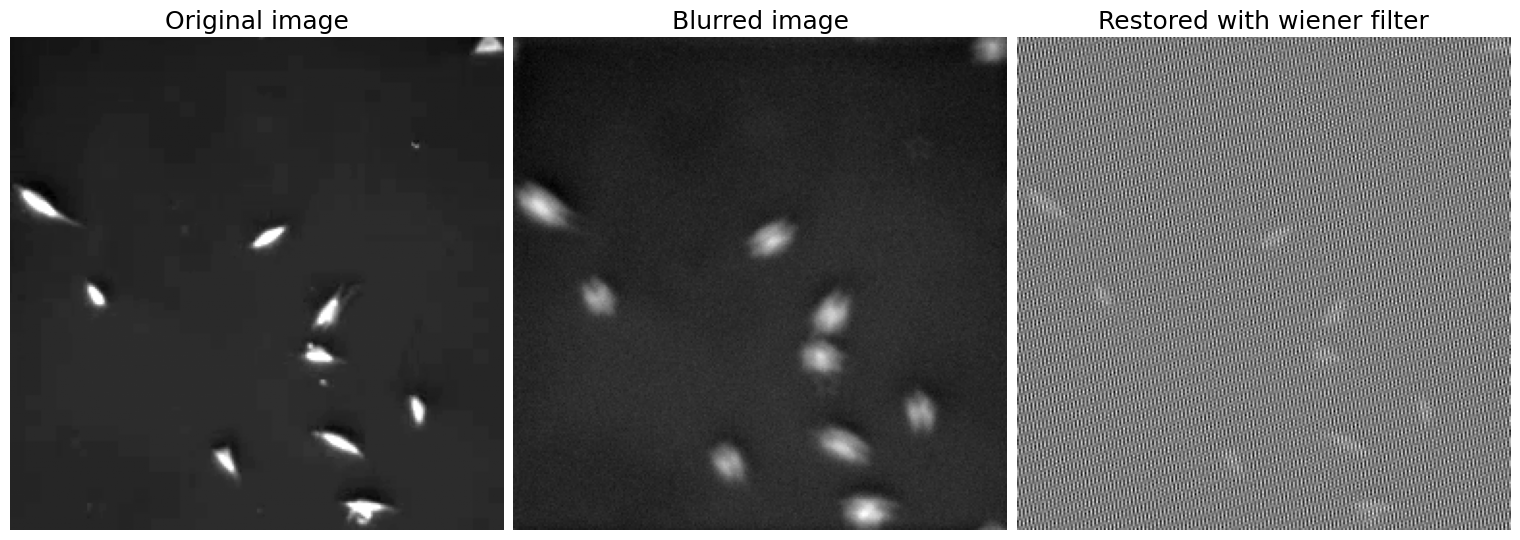

In [96]:
show_images(gt, "Original image", distorted, "Blurred image", x_hat_wf, "Restored with wiener filter", font=18)

From the results and from the formulation of the solution you can see that the Wiener filter without regularization approximates the inverse filter, that we saw in the seminar. The image is dominated by the amplified noise. One commonly used solution to avoid this issue is to add regularization into the optimization scheme by applying constraint on the solution.

## Regularized Wiener filter

With inclusion of a regularization the solution yields the form of

$\hat{\mathbf{x}} = \arg\!\min_{\mathbf{x}}\frac{1}{2}||\mathbf{y}-\mathbf{Kx}||^{2}_{2}+\alpha||\mathbf{Lx}||^2_{2}$.

Here regularization term is represented by the Laplacian filter acting and l2-norm.

Solution of this equation yields the form of

$\hat{\mathbf{x}} = (\mathbf{K}^{\top}\mathbf{K}+\alpha\mathbf{L}^{\top}\mathbf{L})^{-1}\mathbf{K}^{\top}\mathbf{y}$.

Again, reformulation of the solution in the frequence domain results in

$X(u,v) = \frac{K^{*}(u,v)}{|K(u,v)|^{2} + \alpha|L(u,v)|^{2}}Y(u,v)$.

*2 points*

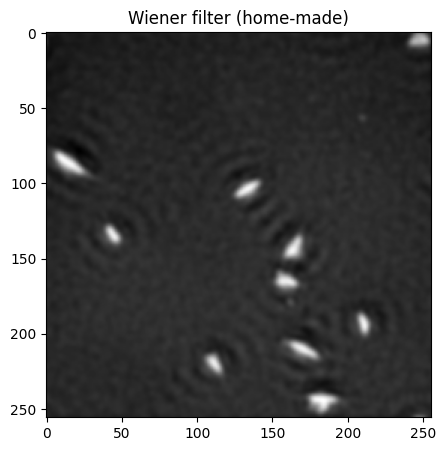

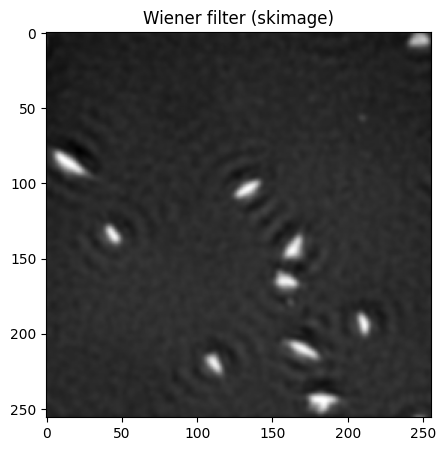

In [97]:
# SOLUTION

laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

alpha = 0.1  # you can select another value, but remember that alpha >= 0
reg_param = alpha

# Perform all necessary preparations with the PSF
"""
YOUR CODE HERE
"""
# Perform all necessary preparations with the regularization filter
"""
YOUR CODE HERE
"""

from numpy import ndarray, linalg
from scipy.fft import fft2, ifft2, ifftshift, fftshift

Y: ndarray = fft2(distorted)

k_padding = ((distorted.shape[0] - psf.shape[0] + 1) // 2, (distorted.shape[1] - psf.shape[1] + 1) // 2)
K = np.zeros(distorted.shape)
K[k_padding[0] : k_padding[0] + psf.shape[0], k_padding[1] : k_padding[1] + psf.shape[1]] = psf
K: ndarray = fft2(ifftshift(K))

l_padding = ((distorted.shape[0] - laplacian.shape[0] + 1) // 2, (distorted.shape[1] - laplacian.shape[1] + 1) // 2)
L = np.zeros(distorted.shape)
L[l_padding[0] : l_padding[0] + laplacian.shape[0], l_padding[1] : l_padding[1] + laplacian.shape[1]] = laplacian
L: ndarray = fft2(ifftshift(L))

wiener_filter = K.conj() / (np.abs(K) ** 2 + reg_param * np.abs(L) ** 2)

X_hat_wf_reg = wiener_filter * Y

x_hat_wf_reg = ifft2(X_hat_wf_reg).real
x_hat_wf_reg = x_hat_wf_reg / x_hat_wf_reg.max()

plt.figure(figsize=(5, 5))
plt.imshow(x_hat_wf_reg, cmap="gray")
plt.title("Wiener filter (home-made)")
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(wiener(distorted, psf, reg_param), cmap="gray")
plt.title("Wiener filter (skimage)")
plt.show()

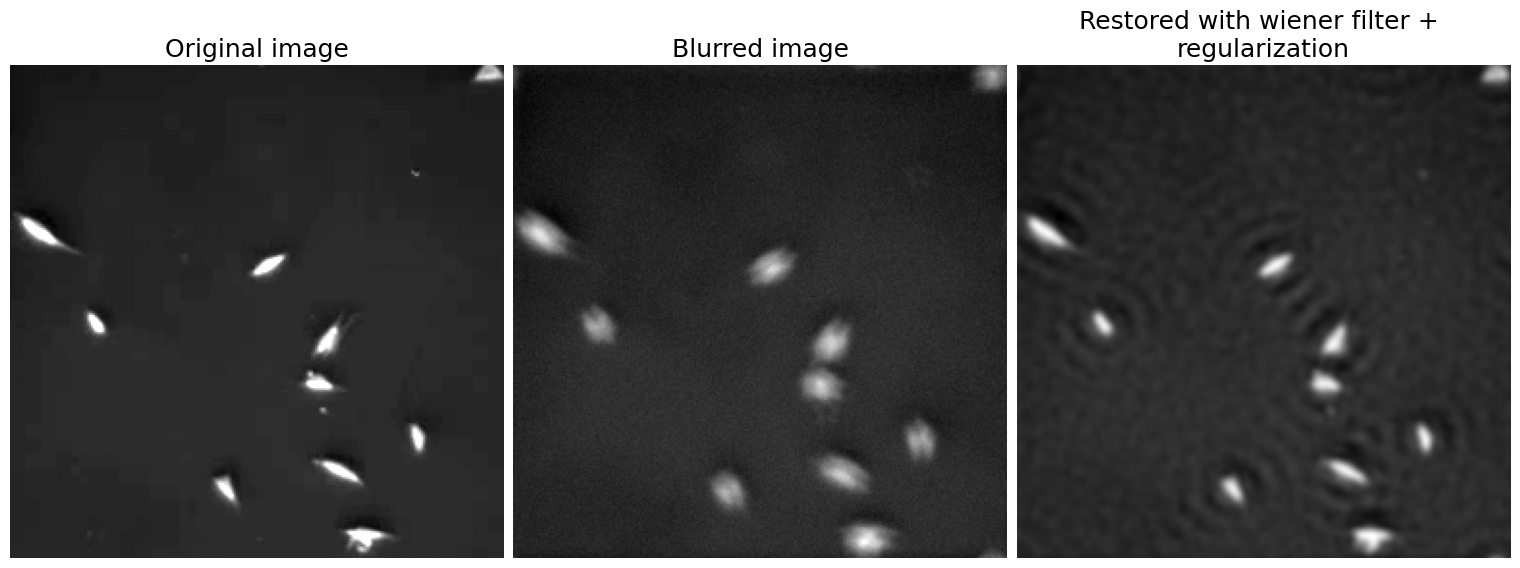

In [98]:
show_images(
    gt,
    "Original image",
    distorted,
    "Blurred image",
    x_hat_wf_reg,
    "Restored with wiener filter + \nregularization",
    font=18,
)

## Explore existing python libraries

**c)** In this exercise, you will evaluate the performance of different deconvolution algorithms by comparing their results. First, you will use a subjective (visual) test to determine which method appears most effective. Then, to support these observations with an objective measure, select a suitable image quality metric.

You can use any open source Python libraries or functions to implement or calculate these metrics - scikit-image, scipy or other packages are all acceptable. By combining visual inspection and quantitative analysis, you will gain a more comprehensive understanding of the strengths and limitations of each deconvolution algorithm.

- Which deconvolution algorithm proved to work best visually? (1 point)

- Suggest a quantitative image quality metric that supports your visual observations, and justify your choice. (1 point)

*2 points*

In [ ]:
from skimage.metrics import structural_similarity

print(
    f"SSIM scores: naive {structural_similarity(gt, x_hat_naive, data_range=1.0)}, wiener {structural_similarity(gt, x_hat_wf, data_range=1.0)}, wiener_reg {structural_similarity(gt, x_hat_wf_reg, data_range=1.0)}"
)


SSIM scores: naive 0.0014107085419186906, wiener 0.003770398354622695, wiener_reg 0.8702747533848204


**Answer:**
1. Visually Wiener with regularization looks the best.
2. Structural Similarity Index Measure - unlike pixel-wise metrics it better correlates with the human perception as it focuses on structure. The metric confirms the visual examination results.

### Additional questions:

* For the regularization task we used the Laplacian kernel. What other kernels can be used? Try some of them and compare the results.

* You can also play with the different value of the regularization parameter and see how it affects the result.